<a href="https://colab.research.google.com/github/msakasai/notebooks/blob/master/dlworkshop_13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pythonでは文字に番号（Unicodeのコードポイント）が割り振られている

In [ ]:
print('0')
print(ord('0'))  # 48
print(chr(48))  # '0'

0
48
0


MNISTの手書き数字を生成してみるコード

In [ ]:
import torch
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from torchvision.datasets import MNIST, CIFAR10  # CIFAR10もインポートしておく
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class Encoder(torch.nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = torch.nn.Linear(input_size, 512)
        self.fc2 = torch.nn.Linear(512, 64)
        self.fc3 = torch.nn.Linear(64, 16)
        self.fc4 = torch.nn.Linear(16, 2)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

class Decoder(torch.nn.Module):
    def __init__(self, output_size):
        super().__init__()
        self.fc1 = torch.nn.Linear(2, 16)
        self.fc2 = torch.nn.Linear(16, 64)
        self.fc3 = torch.nn.Linear(64, 512)
        self.fc4 = torch.nn.Linear(512, output_size)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.tanh(self.fc4(x))  # -1 ~ 1に変換
        return x

class AutoEncoder(torch.nn.Module):
    def __init__(self, org_size):
        super().__init__()
        self.enc = Encoder(org_size)
        self.dec = Decoder(org_size)
    def forward(self, x):
        x = self.enc(x)  # エンコード
        x = self.dec(x)  # デコード
        return x

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = MNIST('./data', train=True, transform=transform, download=True)
testset = MNIST('./data', train=False, transform=transform, download=True)

batch_size = 50
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

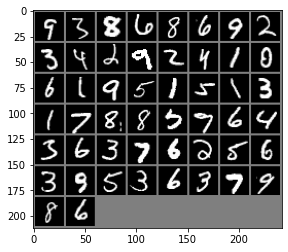

In [ ]:
def imshow(img):
    img = torchvision.utils.make_grid(img)
    img = img / 2 + 0.5
    npimg = img.detach().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

iterator = iter(trainloader)
x, _ = next(iterator)
imshow(x)

In [ ]:
def train(net, criterion, optimizer, epochs, trainloader):
    losses = []
    output_and_label = []

    for epoch in range(1, epochs+1):
        print(f'epoch: {epoch}, ', end='')
        running_loss = 0.0
        for counter, (img, _) in enumerate(trainloader, 1):
            optimizer.zero_grad()
            img = img.reshape(-1, input_size)
            output = net(img)
            loss = criterion(output, img)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / counter
        losses.append(avg_loss)
        print('loss:', avg_loss)
        output_and_label.append((output, img))
    print('finished')
    return output_and_label, losses

input_size = 28 * 28
net = AutoEncoder(input_size)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.1)
EPOCHS = 100

output_and_label, losses = train(net, criterion, optimizer, EPOCHS, trainloader)

epoch: 1, loss: 0.3181317442034682
epoch: 2, loss: 0.24936380000164113
epoch: 3, loss: 0.2430733738342921
epoch: 4, loss: 0.23802122785399357
epoch: 5, loss: 0.22845558463285368
epoch: 6, loss: 0.21962097365409136
epoch: 7, loss: 0.21534865433971087
epoch: 8, loss: 0.21258495077490808
epoch: 9, loss: 0.2104314753289024
epoch: 10, loss: 0.20856376094122728
epoch: 11, loss: 0.20661228376130264
epoch: 12, loss: 0.20465643227100372
epoch: 13, loss: 0.20275959490487974
epoch: 14, loss: 0.20079662140458823
epoch: 15, loss: 0.19875485708316168
epoch: 16, loss: 0.19668941179911295
epoch: 17, loss: 0.19450852205355962
epoch: 18, loss: 0.19246000821391743
epoch: 19, loss: 0.19041996096571287
epoch: 20, loss: 0.18856111257026592
epoch: 21, loss: 0.18681109509120386
epoch: 22, loss: 0.18530945776651303
epoch: 23, loss: 0.1839424869666497
epoch: 24, loss: 0.1827089263871312
epoch: 25, loss: 0.18150208212435245
epoch: 26, loss: 0.18036395641664663
epoch: 27, loss: 0.17927613050987323
epoch: 28, loss

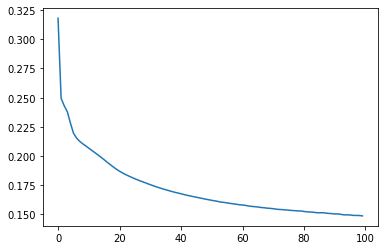

In [ ]:
plt.plot(losses)

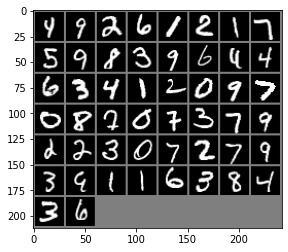

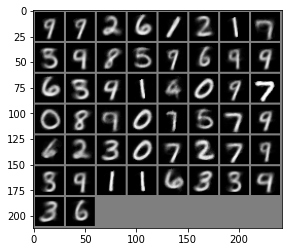

In [ ]:
output, org = output_and_label[-1]
imshow(org.reshape(-1, 1, 28, 28))
imshow(output.reshape(-1, 1, 28, 28))

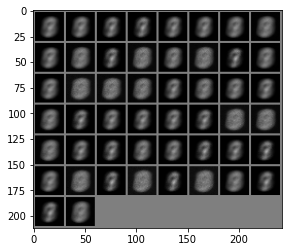

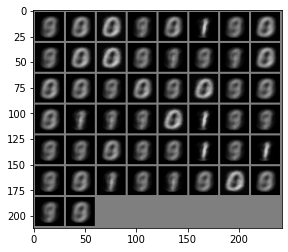

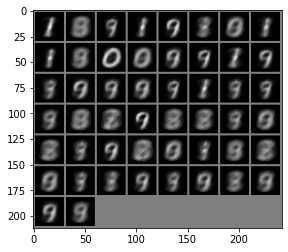

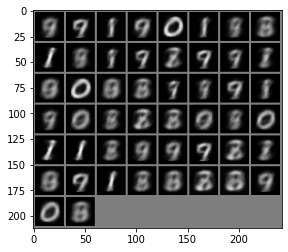

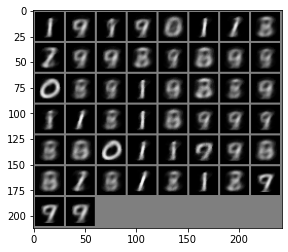

In [ ]:
for img, _ in output_and_label[0:10:2]:
    imshow(img.reshape(-1, 1, 28, 28))

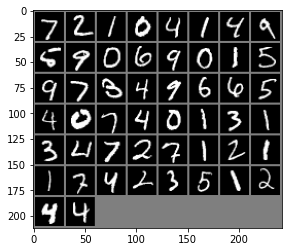

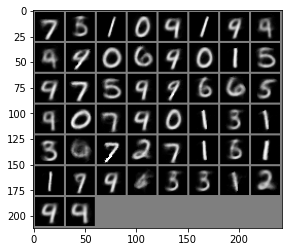

In [ ]:
iterator = iter(testloader)
img, _ = next(iterator)
img = img.reshape(-1, 28 * 28)
output = net(img)
imshow(img.reshape(-1, 1, 28, 28))
imshow(output.reshape(-1, 1, 28, 28))

In [ ]:
sampleloader = DataLoader(testset, batch_size=1500)
iterator = iter(sampleloader)
img, label = next(iterator)
z = net.enc(img.reshape(-1, 28 * 28))
z = z.detach().numpy()
print(z.shape)  # (1500, 2)

(1500, 2)


In [ ]:
set_list = [set() for x in range(10)]
for coord, lbl in zip(z.tolist(), label):
    set_list[lbl].add(tuple(coord))

In [ ]:
for idx in range(10):
    print(f'items in set_list[{idx}]:')
    for cnt, item in enumerate(set_list[idx]):
        print(item)
        if cnt > 5:
            break

items in set_list[0]:
(6.029038906097412, 9.012361526489258)
(5.189882755279541, 3.073603630065918)
(5.498093128204346, 3.260512351989746)
(5.9968061447143555, 3.1625313758850098)
(3.219101905822754, 7.238833904266357)
(5.087274074554443, 3.7118496894836426)
(5.478460788726807, 3.2082369327545166)
items in set_list[1]:
(18.202316284179688, -29.523229598999023)
(11.356987953186035, -34.01761245727539)
(12.581255912780762, -26.21786117553711)
(14.607175827026367, -24.1435604095459)
(8.118223190307617, -17.450891494750977)
(9.113048553466797, -25.674482345581055)
(9.296470642089844, -25.547807693481445)
items in set_list[2]:
(2.5632412433624268, -4.859387397766113)
(-3.876455545425415, -7.59119176864624)
(-4.850790977478027, -8.52607536315918)
(-6.168544292449951, -5.282454967498779)
(-5.861690998077393, -5.1307244300842285)
(-5.307150363922119, -5.681004047393799)
(-3.3831496238708496, -4.852970123291016)
items in set_list[3]:
(-2.226367235183716, -0.649398148059845)
(-2.332001209259033,

['0: r', '1: g', '2: b', '3: c', '4: k', '5: y', '6: orange', '7: lightgreen', '8: hotpink', '9: yellow']


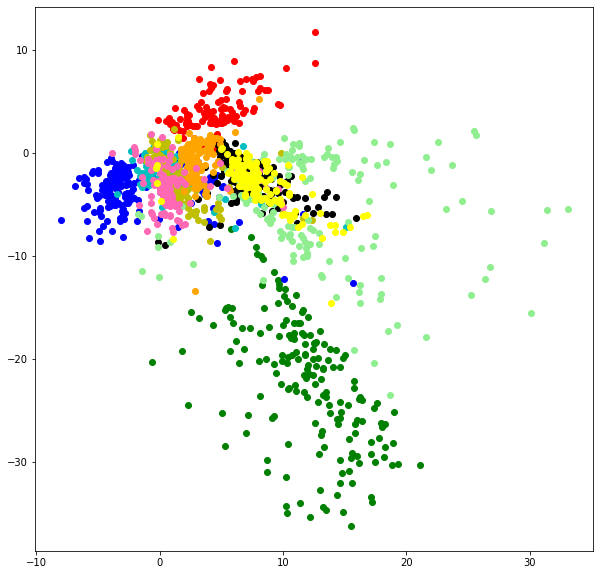

In [ ]:
colorlist = ["r", "g", "b", "c", "k", "y", "orange", "lightgreen", "hotpink", "yellow"]
plt.figure(figsize=(10, 10))
for idx in range(10):
    for x, y in set_list[idx]:
        plt.scatter(x, y, c=colorlist[idx])
description = [f"{idx}: {colorlist[idx]}" for idx in range(10)]
print(description)

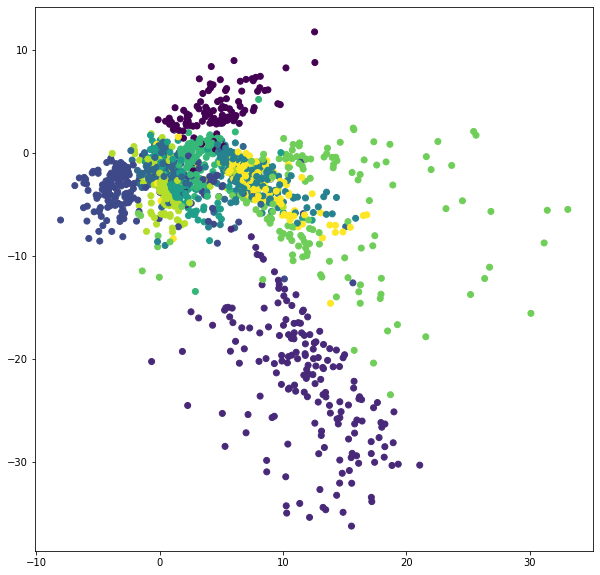

In [ ]:
iterator = iter(sampleloader)
img, label = next(iterator)
z = net.enc(img.reshape(-1, 28 * 28))
z = z.detach().numpy()
plt.figure(figsize=(10, 10))
plt.scatter(z[:, 0], z[:, 1], c=label)

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = CIFAR10('./data', train=True, transform=transform, download=True)
testset = CIFAR10('./data', train=False, transform=transform, download=True)

batch_size = 50
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


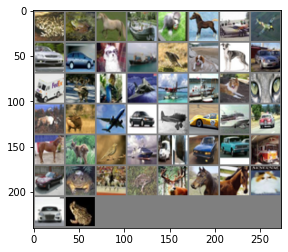

In [ ]:
iterator = iter(trainloader)
img, _ = next(iterator)
imshow(img)

In [ ]:
input_size = 3 * 32 * 32
net2 = AutoEncoder(input_size)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(net2.parameters(), lr=0.1)
EPOCHS = 100

output_and_label2, losses2 = train(net2, criterion, optimizer, EPOCHS, trainloader)

epoch: 1, loss: 0.2561939200013876
epoch: 2, loss: 0.2531275173872709
epoch: 3, loss: 0.25088174909353256
epoch: 4, loss: 0.24900068129599096
epoch: 5, loss: 0.2411595085412264
epoch: 6, loss: 0.214716071292758
epoch: 7, loss: 0.20525734308362006
epoch: 8, loss: 0.18499578934907912
epoch: 9, loss: 0.17769386832416056
epoch: 10, loss: 0.17385233573615552
epoch: 11, loss: 0.16188599517196417
epoch: 12, loss: 0.15639072627574205
epoch: 13, loss: 0.15392512360215188
epoch: 14, loss: 0.15230695443600417
epoch: 15, loss: 0.15115966633707284
epoch: 16, loss: 0.15048454973101616
epoch: 17, loss: 0.15001572678238154
epoch: 18, loss: 0.14968409799039364
epoch: 19, loss: 0.14942945862561463
epoch: 20, loss: 0.14922648299485444
epoch: 21, loss: 0.14906125880032778
epoch: 22, loss: 0.1489339629635215
epoch: 23, loss: 0.14882086499035357
epoch: 24, loss: 0.14872150523215533
epoch: 25, loss: 0.14863128228485584
epoch: 26, loss: 0.14856323815137149
epoch: 27, loss: 0.14848308412730693
epoch: 28, loss:

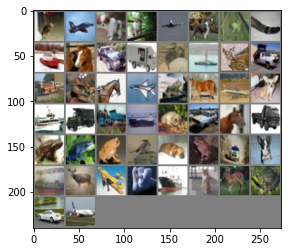

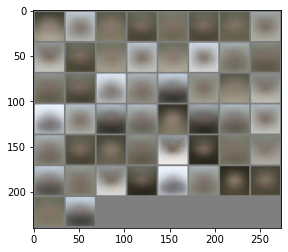

In [ ]:
output, org = output_and_label2[-1]
imshow(org.reshape(-1, 3, 32, 32))
imshow(output.reshape(-1, 3, 32, 32))